# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.01669834 -0.18364389  0.0382302   0.26422623] 0 1.0 False {}
state, action, reward, done, info: [-0.02037121  0.01091213  0.04351473 -0.01615762] 1 1.0 False {}
state, action, reward, done, info: [-0.02015297  0.20538389  0.04319157 -0.29479983] 1 1.0 False {}
state, action, reward, done, info: [-0.01604529  0.00967363  0.03729558  0.01118615] 0 1.0 False {}
state, action, reward, done, info: [-0.01585182  0.20424142  0.0375193  -0.26950022] 1 1.0 False {}
state, action, reward, done, info: [-0.01176699  0.39880842  0.0321293  -0.55011724] 1 1.0 False {}
state, action, reward, done, info: [-0.00379082  0.59346469  0.02112695 -0.83250657] 1 1.0 False {}
state, action, reward, done, info: [ 0.00807847  0.78829167  0.00447682 -1.11847095] 1 1.0 False {}
state, action, reward, done, info: [ 0.0238443   0.98335459 -0.0178926  -1.40974623] 1 1.0 False {}
state, action, reward, done, info: [ 0.0435114   1.17869383 -0.04608752 -1.70796832] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [7]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [9]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [13]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
state, reward, action

(array([ 0.01856029, -0.18582821, -0.01350325,  0.2122994 ]), 1.0, 0)

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 25.0 Average loss: 0.0136 Explore P: 0.9974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 37.0 Average loss: 0.0909 Explore P: 0.9937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 32.0 Average loss: 0.2207 Explore P: 0.9904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 29.0 Average loss: 0.3257 Explore P: 0.9875
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 36 Total reward: 10.0 Average loss: 761628.8750 Explore P: 0.9164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 32.0 Average loss: 955517.3750 Explore P: 0.9134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 30.0 Average loss: 1341311.3750 Explore P: 0.9106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 18.0 Average loss: 1808347.1250 Explore P: 0.9089
-------------------------------------------------------------------------------
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 23.0 Average loss: 2993476608.0000 Explore P: 0.8336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 26.0 Average loss: 3141732352.0000 Explore P: 0.8314
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 44.0 Average loss: 3300986112.0000 Explore P: 0.8277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 17.0 Average loss: 3909384448.0000 Explore P: 0.8262
-------------------------------------------------------------------------------
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 107 Total reward: 138.0 Average loss: 728738758656.0000 Explore P: 0.7255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 23.0 Average loss: 1143584325632.0000 Explore P: 0.7238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 64.0 Average loss: 1205106900992.0000 Explore P: 0.7192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 12.0 Average loss: 1360930668544.0000 Explore P: 0.7183
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 141 Total reward: 140.0 Average loss: 74231245176832.0000 Explore P: 0.5800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 13.0 Average loss: 97684375470080.0000 Explore P: 0.5792
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 151.0 Average loss: 93507821764608.0000 Explore P: 0.5706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 38.0 Average loss: 133698447998976.0000 Explore P: 0.5684
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 175 Total reward: 175.0 Average loss: 66144845168640.0000 Explore P: 0.3871
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 120.0 Average loss: 103630631862272.0000 Explore P: 0.3826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 25.0 Average loss: 119774138859520.0000 Explore P: 0.3816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 15.0 Average loss: 159095923408896.0000 Explore P: 0.3810
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Average loss: 141675720605696.0000 Explore P: 0.2465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Average loss: 110162010439680.0000 Explore P: 0.2419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 199.0 Average loss: 87121549328384.0000 Explore P: 0.2373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 199.0 Average loss: 73823684657152.0000 Explore P: 0.2328
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 243 Total reward: 199.0 Average loss: 115911235207168.0000 Explore P: 0.1298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 154.0 Average loss: 109856212123648.0000 Explore P: 0.1280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 162.0 Average loss: 124515875028992.0000 Explore P: 0.1261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 185.0 Average loss: 108181174878208.0000 Explore P: 0.1239
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Average loss: 16199446429696.0000 Explore P: 0.0764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average loss: 23284223574016.0000 Explore P: 0.0751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average loss: 22327379099648.0000 Explore P: 0.0738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 199.0 Average loss: 17063048380416.0000 Explore P: 0.0725
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 311 Total reward: 199.0 Average loss: 8714689970176.0000 Explore P: 0.0457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Average loss: 5183643844608.0000 Explore P: 0.0450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 199.0 Average loss: 3547762786304.0000 Explore P: 0.0443
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 199.0 Average loss: 1429534408704.0000 Explore P: 0.0437
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 345 Total reward: 11.0 Average loss: 1275706218643456.0000 Explore P: 0.0347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 10.0 Average loss: 1319150215495680.0000 Explore P: 0.0346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 10.0 Average loss: 1344884585791488.0000 Explore P: 0.0346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 12.0 Average loss: 1331871103320064.0000 Explore P: 0.0346
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 379 Total reward: 199.0 Average loss: 10566981648384.0000 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 199.0 Average loss: 9222309806080.0000 Explore P: 0.0233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 199.0 Average loss: 8195512205312.0000 Explore P: 0.0231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 382 Total reward: 199.0 Average loss: 7384414552064.0000 Explore P: 0.0228
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 413 Total reward: 199.0 Average loss: 358249329065984.0000 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 199.0 Average loss: 344315549188096.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 199.0 Average loss: 328226366816256.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Average loss: 367372175147008.0000 Explore P: 0.0165
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 447 Total reward: 199.0 Average loss: 249903208988672.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 199.0 Average loss: 202244003725312.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 199.0 Average loss: 216836037672960.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 199.0 Average loss: 280869084332032.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 481 Total reward: 199.0 Average loss: 337414342049792.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 482 Total reward: 199.0 Average loss: 380715766120448.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199.0 Average loss: 351763525795840.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 199.0 Average loss: 302525349625856.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 515 Total reward: 199.0 Average loss: 340187078983680.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 199.0 Average loss: 332648002093056.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 517 Total reward: 199.0 Average loss: 307663271362560.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 518 Total reward: 199.0 Average loss: 286795669438464.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 549 Total reward: 199.0 Average loss: 340470681042944.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 550 Total reward: 199.0 Average loss: 288144859594752.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 551 Total reward: 199.0 Average loss: 296205204586496.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 552 Total reward: 199.0 Average loss: 302878946230272.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 583 Total reward: 199.0 Average loss: 339018378117120.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 199.0 Average loss: 365357801930752.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 199.0 Average loss: 359157412659200.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 199.0 Average loss: 313070299643904.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 617 Total reward: 199.0 Average loss: 281270043017216.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 199.0 Average loss: 273918032084992.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 619 Total reward: 199.0 Average loss: 247198436556800.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 620 Total reward: 199.0 Average loss: 240667703902208.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 651 Total reward: 199.0 Average loss: 289051701673984.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 199.0 Average loss: 284189261824000.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 199.0 Average loss: 324913369972736.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 199.0 Average loss: 326494756798464.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 685 Total reward: 199.0 Average loss: 338334337466368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 199.0 Average loss: 338937478381568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 199.0 Average loss: 336945183981568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 199.0 Average loss: 325483728207872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 719 Total reward: 199.0 Average loss: 321346097643520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 199.0 Average loss: 351099752022016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 199.0 Average loss: 366496337362944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 199.0 Average loss: 350182206078976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 753 Total reward: 199.0 Average loss: 264442294042624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 199.0 Average loss: 275663902736384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 199.0 Average loss: 263283944718336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 756 Total reward: 199.0 Average loss: 257805462274048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 787 Total reward: 199.0 Average loss: 243793483792384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 199.0 Average loss: 236954335576064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 199.0 Average loss: 248786970476544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 199.0 Average loss: 265219850895360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 821 Total reward: 199.0 Average loss: 252976711073792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 199.0 Average loss: 246143837536256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 199.0 Average loss: 262949306368000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 824 Total reward: 199.0 Average loss: 265396363984896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 855 Total reward: 199.0 Average loss: 239478954262528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 199.0 Average loss: 246225844568064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 199.0 Average loss: 241493981790208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 199.0 Average loss: 206828193447936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 889 Total reward: 199.0 Average loss: 231945799729152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 199.0 Average loss: 252155936112640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 199.0 Average loss: 283972198203392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 892 Total reward: 199.0 Average loss: 247104366706688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 923 Total reward: 199.0 Average loss: 290709458386944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 199.0 Average loss: 266399725387776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 199.0 Average loss: 246538487988224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 926 Total reward: 199.0 Average loss: 225457916084224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 957 Total reward: 199.0 Average loss: 305953069072384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 199.0 Average loss: 290332541452288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 959 Total reward: 199.0 Average loss: 271110197215232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 960 Total reward: 199.0 Average loss: 261446403358720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 991 Total reward: 199.0 Average loss: 315277409517568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 199.0 Average loss: 312626609389568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 199.0 Average loss: 296196715315200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 199.0 Average loss: 286415464169472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1025 Total reward: 199.0 Average loss: 221955655467008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 199.0 Average loss: 228743616397312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1027 Total reward: 199.0 Average loss: 244175232565248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 199.0 Average loss: 271203646308352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1059 Total reward: 199.0 Average loss: 244566812786688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1060 Total reward: 199.0 Average loss: 205324988448768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1061 Total reward: 199.0 Average loss: 204209572020224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1062 Total reward: 199.0 Average loss: 219112068349952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1093 Total reward: 199.0 Average loss: 212878812512256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1094 Total reward: 199.0 Average loss: 186120092516352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1095 Total reward: 199.0 Average loss: 217677163397120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1096 Total reward: 199.0 Average loss: 248181866627072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1127 Total reward: 199.0 Average loss: 209085500751872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 199.0 Average loss: 203208022556672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 199.0 Average loss: 238854992822272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1130 Total reward: 199.0 Average loss: 303195867840512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1161 Total reward: 199.0 Average loss: 342099480281088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 199.0 Average loss: 331581642244096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1163 Total reward: 199.0 Average loss: 269421318766592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1164 Total reward: 199.0 Average loss: 218687923552256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1195 Total reward: 199.0 Average loss: 258875144011776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 199.0 Average loss: 286582665904128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1197 Total reward: 199.0 Average loss: 289615751675904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 199.0 Average loss: 271412807860224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1229 Total reward: 199.0 Average loss: 248005152210944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 199.0 Average loss: 282894161412096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 199.0 Average loss: 286241350221824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 199.0 Average loss: 246778788052992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1263 Total reward: 199.0 Average loss: 261113979600896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1264 Total reward: 199.0 Average loss: 278928396648448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 199.0 Average loss: 256022564306944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1266 Total reward: 199.0 Average loss: 210383168077824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1297 Total reward: 199.0 Average loss: 275255629185024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 199.0 Average loss: 274096474554368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 199.0 Average loss: 259702227206144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1300 Total reward: 199.0 Average loss: 257785463832576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1331 Total reward: 199.0 Average loss: 256098833530880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 199.0 Average loss: 275243969019904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 199.0 Average loss: 295395703914496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1334 Total reward: 199.0 Average loss: 289201186668544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1365 Total reward: 199.0 Average loss: 289771511349248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1366 Total reward: 199.0 Average loss: 354915260039168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1367 Total reward: 199.0 Average loss: 326579917946880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1368 Total reward: 199.0 Average loss: 300392025948160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1399 Total reward: 199.0 Average loss: 247144917237760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1400 Total reward: 199.0 Average loss: 267686974062592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1401 Total reward: 199.0 Average loss: 279880386215936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1402 Total reward: 199.0 Average loss: 250518144286720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1433 Total reward: 199.0 Average loss: 264003133636608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 199.0 Average loss: 294976206405632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 199.0 Average loss: 282483656491008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 199.0 Average loss: 227046936543232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1467 Total reward: 199.0 Average loss: 203709443211264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1468 Total reward: 199.0 Average loss: 184506661208064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1469 Total reward: 199.0 Average loss: 178262248521728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1470 Total reward: 199.0 Average loss: 214484744404992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1501 Total reward: 199.0 Average loss: 277539276718080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1502 Total reward: 199.0 Average loss: 351918715043840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 199.0 Average loss: 371056585998336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1504 Total reward: 199.0 Average loss: 290499273424896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1535 Total reward: 199.0 Average loss: 236087523934208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1536 Total reward: 199.0 Average loss: 236496317579264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 199.0 Average loss: 220498638143488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1538 Total reward: 199.0 Average loss: 203446493904896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1569 Total reward: 199.0 Average loss: 222399849037824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 199.0 Average loss: 265892986355712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1571 Total reward: 199.0 Average loss: 279951018295296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1572 Total reward: 199.0 Average loss: 308121356468224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1603 Total reward: 199.0 Average loss: 228352891813888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1604 Total reward: 199.0 Average loss: 231972777492480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1605 Total reward: 199.0 Average loss: 261638418595840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1606 Total reward: 199.0 Average loss: 243962363248640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1637 Total reward: 199.0 Average loss: 283924752236544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 199.0 Average loss: 340422060670976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 199.0 Average loss: 325072015327232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 199.0 Average loss: 286570049437696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1671 Total reward: 199.0 Average loss: 263533304479744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 199.0 Average loss: 296925014261760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1673 Total reward: 199.0 Average loss: 262212904026112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1674 Total reward: 199.0 Average loss: 205426742263808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1705 Total reward: 199.0 Average loss: 263793200332800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1706 Total reward: 199.0 Average loss: 230337485471744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 199.0 Average loss: 196982517792768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 199.0 Average loss: 189833511174144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1739 Total reward: 199.0 Average loss: 242922058416128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1740 Total reward: 199.0 Average loss: 192526656995328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1741 Total reward: 199.0 Average loss: 203506690555904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1742 Total reward: 199.0 Average loss: 246492619079680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1773 Total reward: 199.0 Average loss: 292659910410240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1774 Total reward: 199.0 Average loss: 266586640351232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1775 Total reward: 199.0 Average loss: 234910853890048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 199.0 Average loss: 259547323170816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1807 Total reward: 199.0 Average loss: 234644633026560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1808 Total reward: 199.0 Average loss: 229231313289216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1809 Total reward: 199.0 Average loss: 255842477670400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1810 Total reward: 199.0 Average loss: 270170320797696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1841 Total reward: 199.0 Average loss: 256241355980800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 199.0 Average loss: 282333567516672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 199.0 Average loss: 306928295084032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 199.0 Average loss: 289154478899200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1875 Total reward: 199.0 Average loss: 282404937793536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1876 Total reward: 199.0 Average loss: 248829064511488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 199.0 Average loss: 217231946416128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 199.0 Average loss: 204312718344192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1909 Total reward: 199.0 Average loss: 255818603692032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1910 Total reward: 199.0 Average loss: 290042161397760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 199.0 Average loss: 356487687831552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1912 Total reward: 199.0 Average loss: 358646647095296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1943 Total reward: 199.0 Average loss: 273116903243776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 199.0 Average loss: 231812202758144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1945 Total reward: 199.0 Average loss: 244591961833472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1946 Total reward: 199.0 Average loss: 263572177289216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1977 Total reward: 199.0 Average loss: 261499721351168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1978 Total reward: 199.0 Average loss: 264922625736704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1979 Total reward: 199.0 Average loss: 251244513853440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1980 Total reward: 199.0 Average loss: 260419973283840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2011 Total reward: 199.0 Average loss: 262257296539648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2012 Total reward: 199.0 Average loss: 217420589432832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2013 Total reward: 199.0 Average loss: 175427603660800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2014 Total reward: 199.0 Average loss: 199796644118528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2045 Total reward: 199.0 Average loss: 279904562184192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2046 Total reward: 199.0 Average loss: 224727234772992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2047 Total reward: 199.0 Average loss: 262612419870720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2048 Total reward: 199.0 Average loss: 334636135743488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2079 Total reward: 199.0 Average loss: 320374260629504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2080 Total reward: 199.0 Average loss: 321784050089984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2081 Total reward: 199.0 Average loss: 235619624157184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2082 Total reward: 199.0 Average loss: 183880300625920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2113 Total reward: 199.0 Average loss: 291782294241280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2114 Total reward: 199.0 Average loss: 273270901309440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2115 Total reward: 199.0 Average loss: 329719270604800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2116 Total reward: 199.0 Average loss: 356811588763648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2147 Total reward: 199.0 Average loss: 278618219479040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2148 Total reward: 199.0 Average loss: 254420491173888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2149 Total reward: 199.0 Average loss: 254691862642688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2150 Total reward: 199.0 Average loss: 304476942499840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2181 Total reward: 199.0 Average loss: 257949595336704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2182 Total reward: 199.0 Average loss: 251981234962432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2183 Total reward: 199.0 Average loss: 241806323220480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2184 Total reward: 199.0 Average loss: 233885732438016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2215 Total reward: 199.0 Average loss: 257955131817984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2216 Total reward: 199.0 Average loss: 260579440721920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2217 Total reward: 199.0 Average loss: 292571024719872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2218 Total reward: 199.0 Average loss: 261800939487232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2249 Total reward: 199.0 Average loss: 215962984906752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2250 Total reward: 199.0 Average loss: 216160637288448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2251 Total reward: 199.0 Average loss: 248017097588736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2252 Total reward: 199.0 Average loss: 320425565356032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2283 Total reward: 199.0 Average loss: 261779548536832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2284 Total reward: 199.0 Average loss: 221301780250624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2285 Total reward: 199.0 Average loss: 216869558550528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2286 Total reward: 199.0 Average loss: 255238162350080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2317 Total reward: 199.0 Average loss: 256034727788544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2318 Total reward: 199.0 Average loss: 252816471883776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2319 Total reward: 199.0 Average loss: 238707286212608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2320 Total reward: 199.0 Average loss: 206118013894656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2351 Total reward: 199.0 Average loss: 324072663678976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2352 Total reward: 199.0 Average loss: 301615185657856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2353 Total reward: 199.0 Average loss: 238348874547200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2354 Total reward: 199.0 Average loss: 244023331651584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2385 Total reward: 199.0 Average loss: 272923394834432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2386 Total reward: 199.0 Average loss: 297203952254976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2387 Total reward: 199.0 Average loss: 295633604837376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2388 Total reward: 199.0 Average loss: 284456455766016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2419 Total reward: 199.0 Average loss: 280761928253440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 199.0 Average loss: 299633964220416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2421 Total reward: 199.0 Average loss: 311962533625856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2422 Total reward: 199.0 Average loss: 276353781858304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2453 Total reward: 199.0 Average loss: 274093001670656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2454 Total reward: 199.0 Average loss: 326538444668928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2455 Total reward: 199.0 Average loss: 330974743232512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2456 Total reward: 199.0 Average loss: 255563959107584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2487 Total reward: 199.0 Average loss: 219072088244224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2488 Total reward: 199.0 Average loss: 198522448117760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2489 Total reward: 199.0 Average loss: 230606256472064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2490 Total reward: 199.0 Average loss: 259956787904512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2521 Total reward: 199.0 Average loss: 319920940253184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2522 Total reward: 199.0 Average loss: 305819690205184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2523 Total reward: 199.0 Average loss: 267658016587776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2524 Total reward: 199.0 Average loss: 246634973757440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2555 Total reward: 199.0 Average loss: 242953582804992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2556 Total reward: 199.0 Average loss: 244858014924800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2557 Total reward: 199.0 Average loss: 238121241280512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2558 Total reward: 199.0 Average loss: 269796574756864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2589 Total reward: 199.0 Average loss: 238270524948480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2590 Total reward: 199.0 Average loss: 252487604895744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2591 Total reward: 199.0 Average loss: 258181590679552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2592 Total reward: 199.0 Average loss: 226776672370688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2623 Total reward: 199.0 Average loss: 226163834224640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2624 Total reward: 199.0 Average loss: 218888881045504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 199.0 Average loss: 237676963823616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total reward: 199.0 Average loss: 248831295881216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2657 Total reward: 199.0 Average loss: 259186931793920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2658 Total reward: 199.0 Average loss: 283786642194432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2659 Total reward: 199.0 Average loss: 331262271160320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2660 Total reward: 199.0 Average loss: 316740718297088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2691 Total reward: 199.0 Average loss: 198041495666688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2692 Total reward: 199.0 Average loss: 218971559165952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2693 Total reward: 199.0 Average loss: 251332527128576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2694 Total reward: 199.0 Average loss: 224506480164864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2725 Total reward: 199.0 Average loss: 311404456312832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2726 Total reward: 199.0 Average loss: 309711870099456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2727 Total reward: 199.0 Average loss: 259969488257024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2728 Total reward: 199.0 Average loss: 242049374748672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2759 Total reward: 199.0 Average loss: 257194016636928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2760 Total reward: 199.0 Average loss: 227620985765888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2761 Total reward: 199.0 Average loss: 224460678365184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2762 Total reward: 199.0 Average loss: 279092494598144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2793 Total reward: 199.0 Average loss: 239842013216768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2794 Total reward: 199.0 Average loss: 212860894445568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2795 Total reward: 199.0 Average loss: 261290543022080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2796 Total reward: 199.0 Average loss: 318901120401408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2827 Total reward: 199.0 Average loss: 275451654176768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2828 Total reward: 199.0 Average loss: 327700870856704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2829 Total reward: 199.0 Average loss: 340123325562880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2830 Total reward: 199.0 Average loss: 285241965019136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2861 Total reward: 199.0 Average loss: 209806367391744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2862 Total reward: 199.0 Average loss: 218430309400576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2863 Total reward: 199.0 Average loss: 264870800916480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2864 Total reward: 199.0 Average loss: 309628386672640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2895 Total reward: 199.0 Average loss: 241886988075008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2896 Total reward: 199.0 Average loss: 251682885730304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2897 Total reward: 199.0 Average loss: 268956170452992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2898 Total reward: 199.0 Average loss: 287139166158848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2929 Total reward: 199.0 Average loss: 270281771843584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 199.0 Average loss: 227304953348096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2931 Total reward: 199.0 Average loss: 273569535754240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2932 Total reward: 199.0 Average loss: 291199453757440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2963 Total reward: 199.0 Average loss: 255641738280960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2964 Total reward: 199.0 Average loss: 295851339546624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2965 Total reward: 199.0 Average loss: 281934236221440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2966 Total reward: 199.0 Average loss: 249975770447872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2997 Total reward: 199.0 Average loss: 289412982243328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2998 Total reward: 199.0 Average loss: 293906625331200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2999 Total reward: 199.0 Average loss: 275062808641536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3000 Total reward: 199.0 Average loss: 293049242484736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3031 Total reward: 199.0 Average loss: 280289616068608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3032 Total reward: 199.0 Average loss: 264688466132992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3033 Total reward: 199.0 Average loss: 278587248738304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3034 Total reward: 199.0 Average loss: 276196176691200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3065 Total reward: 199.0 Average loss: 233810335629312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3066 Total reward: 199.0 Average loss: 251626883383296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3067 Total reward: 199.0 Average loss: 257702936707072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3068 Total reward: 199.0 Average loss: 285337024724992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3099 Total reward: 199.0 Average loss: 253841761107968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3100 Total reward: 199.0 Average loss: 240654382792704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3101 Total reward: 199.0 Average loss: 235432088436736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3102 Total reward: 199.0 Average loss: 219035077705728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3133 Total reward: 199.0 Average loss: 238595533176832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3134 Total reward: 199.0 Average loss: 215992663801856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3135 Total reward: 199.0 Average loss: 230038700032000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3136 Total reward: 199.0 Average loss: 238999377543168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3167 Total reward: 199.0 Average loss: 269193433841664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3168 Total reward: 199.0 Average loss: 278646052880384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3169 Total reward: 199.0 Average loss: 267253098479616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3170 Total reward: 199.0 Average loss: 273999535800320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3201 Total reward: 199.0 Average loss: 232955670691840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3202 Total reward: 199.0 Average loss: 210031333081088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3203 Total reward: 199.0 Average loss: 215515016462336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3204 Total reward: 199.0 Average loss: 255761410162688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3235 Total reward: 199.0 Average loss: 248155442511872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3236 Total reward: 199.0 Average loss: 217249495384064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3237 Total reward: 199.0 Average loss: 207419489648640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3238 Total reward: 199.0 Average loss: 227721145745408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3269 Total reward: 199.0 Average loss: 319547982741504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3270 Total reward: 199.0 Average loss: 300111007580160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3271 Total reward: 199.0 Average loss: 250333611687936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3272 Total reward: 199.0 Average loss: 201671112130560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3303 Total reward: 199.0 Average loss: 240527144386560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3304 Total reward: 199.0 Average loss: 242667128619008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3305 Total reward: 199.0 Average loss: 262451056607232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3306 Total reward: 199.0 Average loss: 265172941799424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3337 Total reward: 199.0 Average loss: 270916235821056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3338 Total reward: 199.0 Average loss: 302658258731008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3339 Total reward: 199.0 Average loss: 289390400110592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3340 Total reward: 199.0 Average loss: 226431447597056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3371 Total reward: 199.0 Average loss: 215933691887616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3372 Total reward: 199.0 Average loss: 244770857287680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3373 Total reward: 199.0 Average loss: 250446992113664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3374 Total reward: 199.0 Average loss: 223756974817280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3405 Total reward: 199.0 Average loss: 234484477722624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3406 Total reward: 199.0 Average loss: 245977441107968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3407 Total reward: 199.0 Average loss: 251131250868224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3408 Total reward: 199.0 Average loss: 260591251881984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3439 Total reward: 199.0 Average loss: 265038656962560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3440 Total reward: 199.0 Average loss: 322939631173632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3441 Total reward: 199.0 Average loss: 280315587198976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3442 Total reward: 199.0 Average loss: 221006803238912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3473 Total reward: 199.0 Average loss: 190859505041408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3474 Total reward: 199.0 Average loss: 251769170952192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3475 Total reward: 199.0 Average loss: 286772315553792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3476 Total reward: 199.0 Average loss: 271111472283648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3507 Total reward: 199.0 Average loss: 239894458793984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3508 Total reward: 199.0 Average loss: 234120076591104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3509 Total reward: 199.0 Average loss: 206156366610432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3510 Total reward: 199.0 Average loss: 208980391493632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3541 Total reward: 199.0 Average loss: 228234511777792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3542 Total reward: 199.0 Average loss: 272495424831488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3543 Total reward: 199.0 Average loss: 284039709720576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3544 Total reward: 199.0 Average loss: 269370399916032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3575 Total reward: 199.0 Average loss: 245956452810752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3576 Total reward: 199.0 Average loss: 278044220588032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3577 Total reward: 199.0 Average loss: 292770170273792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3578 Total reward: 199.0 Average loss: 246118554271744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3609 Total reward: 199.0 Average loss: 250934705782784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3610 Total reward: 199.0 Average loss: 266437306351616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3611 Total reward: 199.0 Average loss: 288749275578368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3612 Total reward: 199.0 Average loss: 243478810329088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3643 Total reward: 199.0 Average loss: 179286950543360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3644 Total reward: 199.0 Average loss: 191968630013952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3645 Total reward: 199.0 Average loss: 225620084654080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3646 Total reward: 199.0 Average loss: 273052461957120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3677 Total reward: 199.0 Average loss: 227277807812608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3678 Total reward: 199.0 Average loss: 256547070410752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3679 Total reward: 199.0 Average loss: 255242474094592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3680 Total reward: 199.0 Average loss: 253978679967744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3711 Total reward: 199.0 Average loss: 316663509549056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3712 Total reward: 199.0 Average loss: 318662447726592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3713 Total reward: 199.0 Average loss: 308749528989696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3714 Total reward: 199.0 Average loss: 296567324016640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3745 Total reward: 199.0 Average loss: 222447915761664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3746 Total reward: 199.0 Average loss: 232661046001664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3747 Total reward: 199.0 Average loss: 262514742919168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3748 Total reward: 199.0 Average loss: 262377790504960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3779 Total reward: 199.0 Average loss: 202701350633472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3780 Total reward: 199.0 Average loss: 236809749528576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3781 Total reward: 199.0 Average loss: 269345468973056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3782 Total reward: 199.0 Average loss: 260913290543104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3813 Total reward: 199.0 Average loss: 203899294187520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3814 Total reward: 199.0 Average loss: 229280436977664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3815 Total reward: 199.0 Average loss: 274661480857600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3816 Total reward: 199.0 Average loss: 292613571739648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3847 Total reward: 199.0 Average loss: 253353779003392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3848 Total reward: 199.0 Average loss: 232728658182144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3849 Total reward: 199.0 Average loss: 230658064515072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3850 Total reward: 199.0 Average loss: 238969061113856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3881 Total reward: 199.0 Average loss: 273977373097984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3882 Total reward: 199.0 Average loss: 291873830731776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3883 Total reward: 199.0 Average loss: 349648120184832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3884 Total reward: 199.0 Average loss: 311818048241664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3915 Total reward: 199.0 Average loss: 215185243504640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3916 Total reward: 199.0 Average loss: 235327767707648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3917 Total reward: 199.0 Average loss: 229850627440640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3918 Total reward: 199.0 Average loss: 229159355809792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3949 Total reward: 199.0 Average loss: 283630949629952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3950 Total reward: 199.0 Average loss: 321928971681792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3951 Total reward: 199.0 Average loss: 317025662533632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3952 Total reward: 199.0 Average loss: 288948152696832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 3983 Total reward: 199.0 Average loss: 261825601994752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3984 Total reward: 199.0 Average loss: 263503055159296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3985 Total reward: 199.0 Average loss: 279309256228864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3986 Total reward: 199.0 Average loss: 306549532655616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4017 Total reward: 199.0 Average loss: 312931417849856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4018 Total reward: 199.0 Average loss: 308959210635264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4019 Total reward: 199.0 Average loss: 267934874206208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4020 Total reward: 199.0 Average loss: 239723213750272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4051 Total reward: 199.0 Average loss: 228834951561216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4052 Total reward: 199.0 Average loss: 238273796505600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4053 Total reward: 199.0 Average loss: 278610149638144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4054 Total reward: 199.0 Average loss: 277880256856064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4085 Total reward: 199.0 Average loss: 296713956884480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4086 Total reward: 199.0 Average loss: 266455912284160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4087 Total reward: 199.0 Average loss: 188950492741632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4088 Total reward: 199.0 Average loss: 183118011039744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4119 Total reward: 199.0 Average loss: 229478257131520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4120 Total reward: 199.0 Average loss: 222891455021056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4121 Total reward: 199.0 Average loss: 211221894660096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4122 Total reward: 199.0 Average loss: 213066817994752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4153 Total reward: 199.0 Average loss: 302955215454208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4154 Total reward: 199.0 Average loss: 329440299057152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4155 Total reward: 199.0 Average loss: 342760938799104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4156 Total reward: 199.0 Average loss: 330513973772288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4187 Total reward: 199.0 Average loss: 236100593385472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4188 Total reward: 199.0 Average loss: 225261907869696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4189 Total reward: 199.0 Average loss: 206007200382976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4190 Total reward: 199.0 Average loss: 196282471677952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4221 Total reward: 199.0 Average loss: 197488015310848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4222 Total reward: 199.0 Average loss: 228497008099328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4223 Total reward: 199.0 Average loss: 263300738711552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4224 Total reward: 199.0 Average loss: 255274803789824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4255 Total reward: 199.0 Average loss: 327320833359872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4256 Total reward: 199.0 Average loss: 351222125035520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4257 Total reward: 199.0 Average loss: 291349542731776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4258 Total reward: 199.0 Average loss: 210920525529088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4289 Total reward: 199.0 Average loss: 233796444094464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4290 Total reward: 199.0 Average loss: 276981753053184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4291 Total reward: 199.0 Average loss: 260856298340352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4292 Total reward: 199.0 Average loss: 251384066736128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4323 Total reward: 199.0 Average loss: 238965839888384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4324 Total reward: 199.0 Average loss: 257025053294592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4325 Total reward: 199.0 Average loss: 253918718197760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4326 Total reward: 199.0 Average loss: 260756960444416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4357 Total reward: 199.0 Average loss: 228716772851712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4358 Total reward: 199.0 Average loss: 230891737579520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4359 Total reward: 199.0 Average loss: 260549896044544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4360 Total reward: 199.0 Average loss: 255287101489152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4391 Total reward: 199.0 Average loss: 321099774558208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4392 Total reward: 199.0 Average loss: 309485713227776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4393 Total reward: 199.0 Average loss: 292436001685504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4394 Total reward: 199.0 Average loss: 248364083970048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4425 Total reward: 199.0 Average loss: 253471018188800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4426 Total reward: 199.0 Average loss: 232590682357760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4427 Total reward: 199.0 Average loss: 218680071815168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4428 Total reward: 199.0 Average loss: 226340968071168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4459 Total reward: 199.0 Average loss: 244328827977728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4460 Total reward: 199.0 Average loss: 285675421171712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4461 Total reward: 199.0 Average loss: 290928770154496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4462 Total reward: 199.0 Average loss: 266030911848448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4493 Total reward: 199.0 Average loss: 240968888483840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4494 Total reward: 199.0 Average loss: 238392897961984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4495 Total reward: 199.0 Average loss: 231773178953728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4496 Total reward: 199.0 Average loss: 247354011680768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4527 Total reward: 199.0 Average loss: 286272958496768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4528 Total reward: 199.0 Average loss: 277694549852160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4529 Total reward: 199.0 Average loss: 261882929741824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4530 Total reward: 199.0 Average loss: 242658840674304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4561 Total reward: 199.0 Average loss: 269839927083008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4562 Total reward: 199.0 Average loss: 227978021699584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4563 Total reward: 199.0 Average loss: 248958332960768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4564 Total reward: 199.0 Average loss: 286908211003392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4595 Total reward: 199.0 Average loss: 264728345575424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4596 Total reward: 199.0 Average loss: 255629675462656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4597 Total reward: 199.0 Average loss: 267677780148224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4598 Total reward: 199.0 Average loss: 244725944680448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4629 Total reward: 199.0 Average loss: 216637412212736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4630 Total reward: 199.0 Average loss: 213958040485888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4631 Total reward: 199.0 Average loss: 247517505650688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4632 Total reward: 199.0 Average loss: 277502433951744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4663 Total reward: 199.0 Average loss: 339625075802112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4664 Total reward: 199.0 Average loss: 268332980764672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4665 Total reward: 199.0 Average loss: 269562683588608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4666 Total reward: 199.0 Average loss: 308703559417856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4697 Total reward: 199.0 Average loss: 274670054014976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4698 Total reward: 199.0 Average loss: 255945858875392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4699 Total reward: 199.0 Average loss: 241439338397696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4700 Total reward: 199.0 Average loss: 240601668780032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4731 Total reward: 199.0 Average loss: 302757378523136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4732 Total reward: 199.0 Average loss: 260746793451520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4733 Total reward: 199.0 Average loss: 252001921269760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4734 Total reward: 199.0 Average loss: 288636633350144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4765 Total reward: 199.0 Average loss: 211861760901120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4766 Total reward: 199.0 Average loss: 205775054045184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4767 Total reward: 199.0 Average loss: 253807871131648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4768 Total reward: 199.0 Average loss: 267491871817728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4799 Total reward: 199.0 Average loss: 226681780436992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4800 Total reward: 199.0 Average loss: 198481645928448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4801 Total reward: 199.0 Average loss: 207080220786688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4802 Total reward: 199.0 Average loss: 208215719542784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4833 Total reward: 199.0 Average loss: 293038706393088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4834 Total reward: 199.0 Average loss: 283486699126784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4835 Total reward: 199.0 Average loss: 276150056124416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4836 Total reward: 199.0 Average loss: 292112738287616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4867 Total reward: 199.0 Average loss: 240821215428608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4868 Total reward: 199.0 Average loss: 300390012682240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4869 Total reward: 199.0 Average loss: 320857545113600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4870 Total reward: 199.0 Average loss: 293704560541696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4901 Total reward: 199.0 Average loss: 215569391419392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4902 Total reward: 199.0 Average loss: 201709313851392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4903 Total reward: 199.0 Average loss: 235524799332352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4904 Total reward: 199.0 Average loss: 250465799372800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4935 Total reward: 199.0 Average loss: 251448961007616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4936 Total reward: 199.0 Average loss: 271763653001216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4937 Total reward: 199.0 Average loss: 246406954614784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4938 Total reward: 199.0 Average loss: 214722729213952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4969 Total reward: 199.0 Average loss: 213757837967360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4970 Total reward: 199.0 Average loss: 253693718953984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4971 Total reward: 199.0 Average loss: 251803748794368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4972 Total reward: 199.0 Average loss: 228943164604416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5003 Total reward: 199.0 Average loss: 240557158825984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5004 Total reward: 199.0 Average loss: 228708703010816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5005 Total reward: 199.0 Average loss: 219520979435520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5006 Total reward: 199.0 Average loss: 213540187144192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5037 Total reward: 199.0 Average loss: 281884609216512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5038 Total reward: 199.0 Average loss: 266612494041088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5039 Total reward: 199.0 Average loss: 273137958649856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5040 Total reward: 199.0 Average loss: 264932473962496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5071 Total reward: 199.0 Average loss: 272360988999680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5072 Total reward: 199.0 Average loss: 294439369048064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5073 Total reward: 199.0 Average loss: 326991228174336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5074 Total reward: 199.0 Average loss: 383501891272704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5105 Total reward: 199.0 Average loss: 273219026157568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5106 Total reward: 199.0 Average loss: 267682981085184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5107 Total reward: 199.0 Average loss: 276269006585856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5108 Total reward: 199.0 Average loss: 265405222354944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5139 Total reward: 199.0 Average loss: 237376383221760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5140 Total reward: 199.0 Average loss: 261571242622976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5141 Total reward: 199.0 Average loss: 274326876061696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5142 Total reward: 199.0 Average loss: 248568749228032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5173 Total reward: 199.0 Average loss: 286954314792960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5174 Total reward: 199.0 Average loss: 274243560407040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5175 Total reward: 199.0 Average loss: 295785136652288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5176 Total reward: 199.0 Average loss: 326000802004992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5207 Total reward: 199.0 Average loss: 260706981117952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5208 Total reward: 199.0 Average loss: 286066263195648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5209 Total reward: 199.0 Average loss: 262621362126848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5210 Total reward: 199.0 Average loss: 279709006954496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5241 Total reward: 199.0 Average loss: 287235031171072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5242 Total reward: 199.0 Average loss: 300739616309248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5243 Total reward: 199.0 Average loss: 334595568435200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5244 Total reward: 199.0 Average loss: 319860005404672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5275 Total reward: 199.0 Average loss: 209071357558784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5276 Total reward: 199.0 Average loss: 214652315238400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5277 Total reward: 199.0 Average loss: 222285696860160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5278 Total reward: 199.0 Average loss: 227744633847808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5309 Total reward: 199.0 Average loss: 214627182968832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5310 Total reward: 199.0 Average loss: 203879127973888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5311 Total reward: 199.0 Average loss: 197474945859584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5312 Total reward: 199.0 Average loss: 210633719021568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5343 Total reward: 199.0 Average loss: 253956567597056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5344 Total reward: 199.0 Average loss: 237375796019200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5345 Total reward: 199.0 Average loss: 259582538547200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5346 Total reward: 199.0 Average loss: 271618865627136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5377 Total reward: 199.0 Average loss: 223273254125568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5378 Total reward: 199.0 Average loss: 249907336183808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5379 Total reward: 199.0 Average loss: 297935908634624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5380 Total reward: 199.0 Average loss: 321875620134912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5411 Total reward: 199.0 Average loss: 224166255001600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5412 Total reward: 199.0 Average loss: 230041669599232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5413 Total reward: 199.0 Average loss: 226564893573120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5414 Total reward: 199.0 Average loss: 237702599409664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5445 Total reward: 199.0 Average loss: 275715761111040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5446 Total reward: 199.0 Average loss: 318630940114944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5447 Total reward: 199.0 Average loss: 282994120065024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5448 Total reward: 199.0 Average loss: 204502468657152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5479 Total reward: 199.0 Average loss: 209337477758976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5480 Total reward: 199.0 Average loss: 189495114727424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5481 Total reward: 199.0 Average loss: 209968535961600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5482 Total reward: 199.0 Average loss: 262717831118848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5513 Total reward: 199.0 Average loss: 255569579474944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5514 Total reward: 199.0 Average loss: 259518130814976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5515 Total reward: 199.0 Average loss: 245979840249856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5516 Total reward: 199.0 Average loss: 225713164648448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5547 Total reward: 199.0 Average loss: 284515142467584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5548 Total reward: 199.0 Average loss: 241075306364928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5549 Total reward: 199.0 Average loss: 217116015853568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5550 Total reward: 199.0 Average loss: 255742435131392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5581 Total reward: 199.0 Average loss: 236268499763200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5582 Total reward: 199.0 Average loss: 212291442180096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5583 Total reward: 199.0 Average loss: 234908924510208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5584 Total reward: 199.0 Average loss: 275925358870528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5615 Total reward: 199.0 Average loss: 273774570110976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5616 Total reward: 199.0 Average loss: 225615185707008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5617 Total reward: 199.0 Average loss: 189942529523712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5618 Total reward: 199.0 Average loss: 189549791674368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5649 Total reward: 199.0 Average loss: 199790839201792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5650 Total reward: 199.0 Average loss: 225038468907008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5651 Total reward: 199.0 Average loss: 269541410078720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5652 Total reward: 199.0 Average loss: 287431156826112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5683 Total reward: 199.0 Average loss: 231154452004864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5684 Total reward: 199.0 Average loss: 239795540328448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5685 Total reward: 199.0 Average loss: 249115065712640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5686 Total reward: 199.0 Average loss: 242563093102592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5717 Total reward: 199.0 Average loss: 232960183762944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5718 Total reward: 199.0 Average loss: 232391419363328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5719 Total reward: 199.0 Average loss: 237392170582016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5720 Total reward: 199.0 Average loss: 264159044304896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5751 Total reward: 199.0 Average loss: 284377971949568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5752 Total reward: 199.0 Average loss: 332591865528320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5753 Total reward: 199.0 Average loss: 300419607691264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5754 Total reward: 199.0 Average loss: 281584632594432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5785 Total reward: 199.0 Average loss: 215310451867648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5786 Total reward: 199.0 Average loss: 226287868182528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5787 Total reward: 199.0 Average loss: 218507014832128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5788 Total reward: 199.0 Average loss: 227024236969984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5819 Total reward: 199.0 Average loss: 319042317451264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5820 Total reward: 199.0 Average loss: 317611925569536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5821 Total reward: 199.0 Average loss: 305983804932096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5822 Total reward: 199.0 Average loss: 313896644640768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5853 Total reward: 199.0 Average loss: 207447138500608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5854 Total reward: 199.0 Average loss: 235627593334784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5855 Total reward: 199.0 Average loss: 265755731951616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5856 Total reward: 199.0 Average loss: 264565388476416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5887 Total reward: 199.0 Average loss: 284860082028544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5888 Total reward: 199.0 Average loss: 251449883754496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5889 Total reward: 199.0 Average loss: 252541325541376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5890 Total reward: 199.0 Average loss: 245144536219648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5921 Total reward: 199.0 Average loss: 260082684133376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5922 Total reward: 199.0 Average loss: 227629642809344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5923 Total reward: 199.0 Average loss: 275509720121344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5924 Total reward: 199.0 Average loss: 305913172852736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5955 Total reward: 199.0 Average loss: 287458738569216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5956 Total reward: 199.0 Average loss: 293456995942400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5957 Total reward: 199.0 Average loss: 224854255075328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5958 Total reward: 199.0 Average loss: 216507439120384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 5989 Total reward: 199.0 Average loss: 219121866244096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5990 Total reward: 199.0 Average loss: 260744192983040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5991 Total reward: 199.0 Average loss: 306778306772992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5992 Total reward: 199.0 Average loss: 291892419887104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6023 Total reward: 199.0 Average loss: 218895759704064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6024 Total reward: 199.0 Average loss: 208807904935936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6025 Total reward: 199.0 Average loss: 201499246329856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6026 Total reward: 199.0 Average loss: 247230330044416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6057 Total reward: 199.0 Average loss: 270458385596416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6058 Total reward: 199.0 Average loss: 286223264382976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6059 Total reward: 199.0 Average loss: 333254901104640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6060 Total reward: 199.0 Average loss: 336041663791104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6091 Total reward: 199.0 Average loss: 266206971953152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6092 Total reward: 199.0 Average loss: 269409004290048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6093 Total reward: 199.0 Average loss: 267502391132160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6094 Total reward: 199.0 Average loss: 239102339317760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6125 Total reward: 199.0 Average loss: 245605959991296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6126 Total reward: 199.0 Average loss: 208020986396672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6127 Total reward: 199.0 Average loss: 225630150983680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6128 Total reward: 199.0 Average loss: 264058280345600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6159 Total reward: 199.0 Average loss: 267224661098496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6160 Total reward: 199.0 Average loss: 251382070247424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6161 Total reward: 199.0 Average loss: 241174325493760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6162 Total reward: 199.0 Average loss: 254271593381888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6193 Total reward: 199.0 Average loss: 269393149820928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6194 Total reward: 199.0 Average loss: 249629891362816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6195 Total reward: 199.0 Average loss: 266301545119744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6196 Total reward: 199.0 Average loss: 303352265048064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6227 Total reward: 199.0 Average loss: 250884827119616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6228 Total reward: 199.0 Average loss: 262577640701952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6229 Total reward: 199.0 Average loss: 301550392049664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6230 Total reward: 199.0 Average loss: 294627206758400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6261 Total reward: 199.0 Average loss: 281334517858304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6262 Total reward: 199.0 Average loss: 239884258246656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6263 Total reward: 199.0 Average loss: 246319226552320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6264 Total reward: 199.0 Average loss: 261729468547072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6295 Total reward: 199.0 Average loss: 264177818009600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6296 Total reward: 199.0 Average loss: 268291574595584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6297 Total reward: 199.0 Average loss: 240536338300928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6298 Total reward: 199.0 Average loss: 230415851847680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6329 Total reward: 199.0 Average loss: 207234118189056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6330 Total reward: 199.0 Average loss: 197706806984704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6331 Total reward: 199.0 Average loss: 208217279823872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6332 Total reward: 199.0 Average loss: 242734573027328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6363 Total reward: 199.0 Average loss: 238442994728960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6364 Total reward: 199.0 Average loss: 209915838726144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6365 Total reward: 199.0 Average loss: 210482690523136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6366 Total reward: 199.0 Average loss: 233917441376256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6397 Total reward: 199.0 Average loss: 218126037811200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6398 Total reward: 199.0 Average loss: 200455686717440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6399 Total reward: 199.0 Average loss: 220395424710656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6400 Total reward: 199.0 Average loss: 264985372524544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6431 Total reward: 199.0 Average loss: 228665048694784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6432 Total reward: 199.0 Average loss: 295786747265024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6433 Total reward: 199.0 Average loss: 304605355311104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6434 Total reward: 199.0 Average loss: 246220475858944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6465 Total reward: 199.0 Average loss: 221890878636032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6466 Total reward: 199.0 Average loss: 270296401575936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6467 Total reward: 199.0 Average loss: 263764226080768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6468 Total reward: 199.0 Average loss: 231206243270656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6499 Total reward: 199.0 Average loss: 264715041243136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6500 Total reward: 199.0 Average loss: 254494159929344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6501 Total reward: 199.0 Average loss: 298507944591360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6502 Total reward: 199.0 Average loss: 296553868689408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6533 Total reward: 199.0 Average loss: 291104326942720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6534 Total reward: 199.0 Average loss: 325093255282688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6535 Total reward: 199.0 Average loss: 308214033809408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6536 Total reward: 199.0 Average loss: 281104921657344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6567 Total reward: 199.0 Average loss: 276785124081664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6568 Total reward: 199.0 Average loss: 255214556807168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6569 Total reward: 199.0 Average loss: 207484417474560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6570 Total reward: 199.0 Average loss: 221919718670336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6601 Total reward: 199.0 Average loss: 206100364263424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6602 Total reward: 199.0 Average loss: 250914589900800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6603 Total reward: 199.0 Average loss: 276008120877056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6604 Total reward: 199.0 Average loss: 257059060711424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6635 Total reward: 199.0 Average loss: 323871706185728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6636 Total reward: 199.0 Average loss: 254519174758400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6637 Total reward: 199.0 Average loss: 220611901128704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6638 Total reward: 199.0 Average loss: 238280356397056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6669 Total reward: 199.0 Average loss: 251037835329536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6670 Total reward: 199.0 Average loss: 275491953049600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6671 Total reward: 199.0 Average loss: 300028329459712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6672 Total reward: 199.0 Average loss: 317829995823104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6703 Total reward: 199.0 Average loss: 189515297718272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6704 Total reward: 199.0 Average loss: 215439988752384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6705 Total reward: 199.0 Average loss: 245653892497408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6706 Total reward: 199.0 Average loss: 259925800386560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6737 Total reward: 199.0 Average loss: 266475558404096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6738 Total reward: 199.0 Average loss: 221598468538368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6739 Total reward: 199.0 Average loss: 230369462845440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6740 Total reward: 199.0 Average loss: 224435747422208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6771 Total reward: 199.0 Average loss: 267167601786880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6772 Total reward: 199.0 Average loss: 233262509195264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6773 Total reward: 199.0 Average loss: 284536483086336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6774 Total reward: 199.0 Average loss: 319165294444544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6805 Total reward: 199.0 Average loss: 330366703370240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6806 Total reward: 199.0 Average loss: 328550703955968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6807 Total reward: 199.0 Average loss: 327243054186496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6808 Total reward: 199.0 Average loss: 279714174337024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6839 Total reward: 199.0 Average loss: 294731561041920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6840 Total reward: 199.0 Average loss: 302937230278656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6841 Total reward: 199.0 Average loss: 298544284041216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6842 Total reward: 199.0 Average loss: 261340421685248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6873 Total reward: 199.0 Average loss: 220719963176960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6874 Total reward: 199.0 Average loss: 199754348756992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6875 Total reward: 199.0 Average loss: 231291739963392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6876 Total reward: 199.0 Average loss: 280242404982784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6907 Total reward: 199.0 Average loss: 190055071088640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6908 Total reward: 199.0 Average loss: 189261659766784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6909 Total reward: 199.0 Average loss: 191803424768000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6910 Total reward: 199.0 Average loss: 205446455492608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6941 Total reward: 199.0 Average loss: 285348399677440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6942 Total reward: 199.0 Average loss: 278657528496128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6943 Total reward: 199.0 Average loss: 247662376910848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6944 Total reward: 199.0 Average loss: 204506277085184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 6975 Total reward: 199.0 Average loss: 209845525413888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6976 Total reward: 199.0 Average loss: 297192275312640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6977 Total reward: 199.0 Average loss: 315688719745024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6978 Total reward: 199.0 Average loss: 309201406525440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7009 Total reward: 199.0 Average loss: 256457094201344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7010 Total reward: 199.0 Average loss: 305797879824384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7011 Total reward: 199.0 Average loss: 312946819334144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7012 Total reward: 199.0 Average loss: 281668652892160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7043 Total reward: 199.0 Average loss: 284160405012480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7044 Total reward: 199.0 Average loss: 257085853925376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7045 Total reward: 199.0 Average loss: 250231606214656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7046 Total reward: 199.0 Average loss: 254781134209024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7077 Total reward: 199.0 Average loss: 222997856124928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7078 Total reward: 199.0 Average loss: 216300206948352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7079 Total reward: 199.0 Average loss: 237686459727872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7080 Total reward: 199.0 Average loss: 259437734395904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7111 Total reward: 199.0 Average loss: 274173247094784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7112 Total reward: 199.0 Average loss: 299630038351872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7113 Total reward: 199.0 Average loss: 275098460225536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7114 Total reward: 199.0 Average loss: 290251775934464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7145 Total reward: 199.0 Average loss: 237054227120128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7146 Total reward: 199.0 Average loss: 228114437242880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7147 Total reward: 199.0 Average loss: 245005620871168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7148 Total reward: 199.0 Average loss: 263337665363968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7179 Total reward: 199.0 Average loss: 266340501815296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7180 Total reward: 199.0 Average loss: 310353464393728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7181 Total reward: 199.0 Average loss: 289703496515584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7182 Total reward: 199.0 Average loss: 266988689555456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7213 Total reward: 199.0 Average loss: 258597531418624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7214 Total reward: 199.0 Average loss: 259872834715648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7215 Total reward: 199.0 Average loss: 287786934468608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7216 Total reward: 199.0 Average loss: 296780193333248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7247 Total reward: 199.0 Average loss: 255737838174208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7248 Total reward: 199.0 Average loss: 246518137225216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7249 Total reward: 199.0 Average loss: 215883158913024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7250 Total reward: 199.0 Average loss: 221026382249984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7281 Total reward: 199.0 Average loss: 306131612205056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7282 Total reward: 199.0 Average loss: 309710561476608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7283 Total reward: 199.0 Average loss: 263985534337024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7284 Total reward: 199.0 Average loss: 267584800817152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7315 Total reward: 199.0 Average loss: 259641040699392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7316 Total reward: 199.0 Average loss: 279843056910336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7317 Total reward: 199.0 Average loss: 279735984717824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7318 Total reward: 199.0 Average loss: 271275738005504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7349 Total reward: 199.0 Average loss: 254325129478144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7350 Total reward: 199.0 Average loss: 303462524911616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7351 Total reward: 199.0 Average loss: 357183136989184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7352 Total reward: 199.0 Average loss: 363272662417408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7383 Total reward: 199.0 Average loss: 235013245239296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7384 Total reward: 199.0 Average loss: 235155767689216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7385 Total reward: 199.0 Average loss: 274002790580224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7386 Total reward: 199.0 Average loss: 308796505194496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7417 Total reward: 199.0 Average loss: 284851794083840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7418 Total reward: 199.0 Average loss: 288394403905536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7419 Total reward: 199.0 Average loss: 282549389623296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7420 Total reward: 199.0 Average loss: 266823433977856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7451 Total reward: 199.0 Average loss: 286206956929024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7452 Total reward: 199.0 Average loss: 233886688739328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7453 Total reward: 199.0 Average loss: 225224092024832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7454 Total reward: 199.0 Average loss: 238243765288960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7485 Total reward: 199.0 Average loss: 258891787010048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7486 Total reward: 199.0 Average loss: 257846264463360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7487 Total reward: 199.0 Average loss: 266649991118848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7488 Total reward: 199.0 Average loss: 273530830716928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7519 Total reward: 199.0 Average loss: 251725030096896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7520 Total reward: 199.0 Average loss: 282213308432384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7521 Total reward: 199.0 Average loss: 319074999468032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7522 Total reward: 199.0 Average loss: 285947950268416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7553 Total reward: 199.0 Average loss: 258089852862464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7554 Total reward: 199.0 Average loss: 254123500896256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7555 Total reward: 199.0 Average loss: 231709828186112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7556 Total reward: 199.0 Average loss: 264819731070976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7587 Total reward: 199.0 Average loss: 348077806321664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7588 Total reward: 199.0 Average loss: 351105187840000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7589 Total reward: 199.0 Average loss: 327919209545728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7590 Total reward: 199.0 Average loss: 297291831312384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7621 Total reward: 199.0 Average loss: 203390105681920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7622 Total reward: 199.0 Average loss: 219922558877696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7623 Total reward: 199.0 Average loss: 229824085884928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7624 Total reward: 199.0 Average loss: 215749008293888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7655 Total reward: 199.0 Average loss: 229090384674816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7656 Total reward: 199.0 Average loss: 252289734410240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7657 Total reward: 199.0 Average loss: 241377011040256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7658 Total reward: 199.0 Average loss: 221445225447424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7689 Total reward: 199.0 Average loss: 317821238116352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7690 Total reward: 199.0 Average loss: 289194475782144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7691 Total reward: 199.0 Average loss: 256797252255744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7692 Total reward: 199.0 Average loss: 251966269685760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7723 Total reward: 199.0 Average loss: 287725362085888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7724 Total reward: 199.0 Average loss: 316657603969024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7725 Total reward: 199.0 Average loss: 279478504783872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7726 Total reward: 199.0 Average loss: 231968297975808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7757 Total reward: 199.0 Average loss: 194226709069824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7758 Total reward: 199.0 Average loss: 224334480146432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7759 Total reward: 199.0 Average loss: 282698841063424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7760 Total reward: 199.0 Average loss: 309664222806016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7791 Total reward: 199.0 Average loss: 258194945343488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7792 Total reward: 199.0 Average loss: 323008551976960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7793 Total reward: 199.0 Average loss: 307138312273920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7794 Total reward: 199.0 Average loss: 218361673809920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7825 Total reward: 199.0 Average loss: 333018778566656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7826 Total reward: 199.0 Average loss: 321633323581440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7827 Total reward: 199.0 Average loss: 260177324408832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7828 Total reward: 199.0 Average loss: 222435232186368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7859 Total reward: 199.0 Average loss: 253747406045184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7860 Total reward: 199.0 Average loss: 210848081510400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7861 Total reward: 199.0 Average loss: 195471695937536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7862 Total reward: 199.0 Average loss: 257670909001728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7893 Total reward: 199.0 Average loss: 288979358318592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7894 Total reward: 199.0 Average loss: 257069747798016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7895 Total reward: 199.0 Average loss: 227110119538688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7896 Total reward: 199.0 Average loss: 221817679642624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7927 Total reward: 199.0 Average loss: 286641017061376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7928 Total reward: 199.0 Average loss: 246237857054720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7929 Total reward: 199.0 Average loss: 196487707361280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7930 Total reward: 199.0 Average loss: 216788491042816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7961 Total reward: 199.0 Average loss: 199040343998464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7962 Total reward: 199.0 Average loss: 185388991774720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7963 Total reward: 199.0 Average loss: 176059400060928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7964 Total reward: 199.0 Average loss: 171705142083584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 7995 Total reward: 199.0 Average loss: 207743524798464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7996 Total reward: 199.0 Average loss: 199791745171456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7997 Total reward: 199.0 Average loss: 205592014618624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7998 Total reward: 199.0 Average loss: 217770427940864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8029 Total reward: 199.0 Average loss: 250385419730944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8030 Total reward: 199.0 Average loss: 197998780874752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8031 Total reward: 199.0 Average loss: 180609079050240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8032 Total reward: 199.0 Average loss: 214090228170752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8063 Total reward: 199.0 Average loss: 255015847460864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8064 Total reward: 199.0 Average loss: 256886339272704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8065 Total reward: 199.0 Average loss: 270407668072448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8066 Total reward: 199.0 Average loss: 260078523383808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8097 Total reward: 199.0 Average loss: 196712203288576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8098 Total reward: 199.0 Average loss: 198731878105088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8099 Total reward: 199.0 Average loss: 252222558437376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8100 Total reward: 199.0 Average loss: 250145975304192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8131 Total reward: 199.0 Average loss: 256130173370368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8132 Total reward: 199.0 Average loss: 252535268966400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8133 Total reward: 199.0 Average loss: 229992361361408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8134 Total reward: 199.0 Average loss: 256757272150016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8165 Total reward: 199.0 Average loss: 258315372199936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8166 Total reward: 199.0 Average loss: 219926652518400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8167 Total reward: 199.0 Average loss: 213551612428288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8168 Total reward: 199.0 Average loss: 231844784111616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8199 Total reward: 199.0 Average loss: 260273860509696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8200 Total reward: 199.0 Average loss: 249167393849344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8201 Total reward: 199.0 Average loss: 247209173975040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8202 Total reward: 199.0 Average loss: 226986404347904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8233 Total reward: 199.0 Average loss: 237460235747328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8234 Total reward: 199.0 Average loss: 271618580414464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8235 Total reward: 199.0 Average loss: 301577537585152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8236 Total reward: 199.0 Average loss: 280437893103616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8267 Total reward: 199.0 Average loss: 255385130762240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8268 Total reward: 199.0 Average loss: 251112007401472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8269 Total reward: 199.0 Average loss: 258607178317824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8270 Total reward: 199.0 Average loss: 298123343691776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8301 Total reward: 199.0 Average loss: 309752907169792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8302 Total reward: 199.0 Average loss: 292906199941120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8303 Total reward: 199.0 Average loss: 233129834971136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8304 Total reward: 199.0 Average loss: 209569003339776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8335 Total reward: 199.0 Average loss: 233247694913536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8336 Total reward: 199.0 Average loss: 261249992491008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8337 Total reward: 199.0 Average loss: 275960523915264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8338 Total reward: 199.0 Average loss: 261819797078016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8369 Total reward: 199.0 Average loss: 239987102580736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8370 Total reward: 199.0 Average loss: 249023797657600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8371 Total reward: 199.0 Average loss: 249972465336320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8372 Total reward: 199.0 Average loss: 225290227810304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8403 Total reward: 199.0 Average loss: 386853207277568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8404 Total reward: 199.0 Average loss: 383597085196288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8405 Total reward: 199.0 Average loss: 348296279228416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8406 Total reward: 199.0 Average loss: 295325810032640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8437 Total reward: 199.0 Average loss: 271408512892928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8438 Total reward: 199.0 Average loss: 269272370642944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8439 Total reward: 199.0 Average loss: 267154616221696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8440 Total reward: 199.0 Average loss: 257919245352960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8471 Total reward: 199.0 Average loss: 215449987973120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8472 Total reward: 199.0 Average loss: 259967693094912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8473 Total reward: 199.0 Average loss: 305812878655488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8474 Total reward: 199.0 Average loss: 288374539681792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8505 Total reward: 199.0 Average loss: 247959417520128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8506 Total reward: 199.0 Average loss: 293496858607616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8507 Total reward: 199.0 Average loss: 271762042388480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8508 Total reward: 199.0 Average loss: 212582963085312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8539 Total reward: 199.0 Average loss: 234725583093760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8540 Total reward: 199.0 Average loss: 177302289776640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8541 Total reward: 199.0 Average loss: 190849455489024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8542 Total reward: 199.0 Average loss: 214405404950528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8573 Total reward: 199.0 Average loss: 279921322622976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8574 Total reward: 199.0 Average loss: 232602879393792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8575 Total reward: 199.0 Average loss: 218031967961088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8576 Total reward: 199.0 Average loss: 220087562797056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8607 Total reward: 199.0 Average loss: 244554145988608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8608 Total reward: 199.0 Average loss: 237185575944192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8609 Total reward: 199.0 Average loss: 273497561497600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8610 Total reward: 199.0 Average loss: 286206285840384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8641 Total reward: 199.0 Average loss: 281602282225664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8642 Total reward: 199.0 Average loss: 268436680736768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8643 Total reward: 199.0 Average loss: 289390366556160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8644 Total reward: 199.0 Average loss: 304367420833792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8675 Total reward: 199.0 Average loss: 245158192873472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8676 Total reward: 199.0 Average loss: 247759047229440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8677 Total reward: 199.0 Average loss: 283644505620480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8678 Total reward: 199.0 Average loss: 348300272205824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8709 Total reward: 199.0 Average loss: 300852325646336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8710 Total reward: 199.0 Average loss: 307846210125824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8711 Total reward: 199.0 Average loss: 299658458955776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8712 Total reward: 199.0 Average loss: 266309782732800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8743 Total reward: 199.0 Average loss: 277998754332672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8744 Total reward: 199.0 Average loss: 307363361849344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8745 Total reward: 199.0 Average loss: 280764461613056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8746 Total reward: 199.0 Average loss: 257916560998400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8777 Total reward: 199.0 Average loss: 285343702056960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8778 Total reward: 199.0 Average loss: 293130779754496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8779 Total reward: 199.0 Average loss: 302956691849216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8780 Total reward: 199.0 Average loss: 263522952937472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8811 Total reward: 199.0 Average loss: 295567804596224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8812 Total reward: 199.0 Average loss: 257669063507968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8813 Total reward: 199.0 Average loss: 252357011046400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8814 Total reward: 199.0 Average loss: 268081876172800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8845 Total reward: 199.0 Average loss: 237977997410304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8846 Total reward: 199.0 Average loss: 239097507479552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8847 Total reward: 199.0 Average loss: 269286882934784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8848 Total reward: 199.0 Average loss: 300013632618496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8879 Total reward: 199.0 Average loss: 206343499677696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8880 Total reward: 199.0 Average loss: 208465129635840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8881 Total reward: 199.0 Average loss: 217134437236736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8882 Total reward: 199.0 Average loss: 233774600159232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8913 Total reward: 199.0 Average loss: 272246031515648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8914 Total reward: 199.0 Average loss: 277248041025536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8915 Total reward: 199.0 Average loss: 267065361432576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8916 Total reward: 199.0 Average loss: 256505882345472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8947 Total reward: 199.0 Average loss: 272216621056000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8948 Total reward: 199.0 Average loss: 253508683038720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8949 Total reward: 199.0 Average loss: 276738248540160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8950 Total reward: 199.0 Average loss: 286615415029760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8981 Total reward: 199.0 Average loss: 341915165786112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8982 Total reward: 199.0 Average loss: 294145700659200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8983 Total reward: 199.0 Average loss: 294070236741632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8984 Total reward: 199.0 Average loss: 301550358495232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9015 Total reward: 199.0 Average loss: 247458365964288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9016 Total reward: 199.0 Average loss: 267124786331648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9017 Total reward: 199.0 Average loss: 259837065691136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9018 Total reward: 199.0 Average loss: 276875502944256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9049 Total reward: 199.0 Average loss: 257465337774080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9050 Total reward: 199.0 Average loss: 217043504726016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9051 Total reward: 199.0 Average loss: 199004860186624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9052 Total reward: 199.0 Average loss: 217587824721920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9083 Total reward: 199.0 Average loss: 252209707089920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9084 Total reward: 199.0 Average loss: 269113742065664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9085 Total reward: 199.0 Average loss: 247951901327360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9086 Total reward: 199.0 Average loss: 285768299839488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9117 Total reward: 199.0 Average loss: 226529292320768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9118 Total reward: 199.0 Average loss: 223378732482560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9119 Total reward: 199.0 Average loss: 232046647574528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9120 Total reward: 199.0 Average loss: 221470827479040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9151 Total reward: 199.0 Average loss: 208496788242432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9152 Total reward: 199.0 Average loss: 210909519675392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9153 Total reward: 199.0 Average loss: 259932343500800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9154 Total reward: 199.0 Average loss: 302856397651968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9185 Total reward: 199.0 Average loss: 235213498089472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9186 Total reward: 199.0 Average loss: 293686541811712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9187 Total reward: 199.0 Average loss: 310911004835840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9188 Total reward: 199.0 Average loss: 279438306574336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9219 Total reward: 199.0 Average loss: 273942157721600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9220 Total reward: 199.0 Average loss: 305613967982592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9221 Total reward: 199.0 Average loss: 292153540476928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9222 Total reward: 199.0 Average loss: 243635979288576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9253 Total reward: 199.0 Average loss: 295722725408768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9254 Total reward: 199.0 Average loss: 280903058194432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9255 Total reward: 199.0 Average loss: 243026832130048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9256 Total reward: 199.0 Average loss: 228752021782528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9287 Total reward: 199.0 Average loss: 271797509423104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9288 Total reward: 199.0 Average loss: 234661242470400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9289 Total reward: 199.0 Average loss: 232109981564928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9290 Total reward: 199.0 Average loss: 212209720360960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9321 Total reward: 199.0 Average loss: 267834915553280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9322 Total reward: 199.0 Average loss: 253766162972672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9323 Total reward: 199.0 Average loss: 237003610259456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9324 Total reward: 199.0 Average loss: 214129872732160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9355 Total reward: 199.0 Average loss: 250527388532736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9356 Total reward: 199.0 Average loss: 262247498645504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9357 Total reward: 199.0 Average loss: 300462658027520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9358 Total reward: 199.0 Average loss: 281229425377280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9389 Total reward: 199.0 Average loss: 271626482483200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9390 Total reward: 199.0 Average loss: 272408904728576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9391 Total reward: 199.0 Average loss: 299505215864832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9392 Total reward: 199.0 Average loss: 296354689581056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9423 Total reward: 199.0 Average loss: 222649124913152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9424 Total reward: 199.0 Average loss: 238595566731264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9425 Total reward: 199.0 Average loss: 296615340408832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9426 Total reward: 199.0 Average loss: 320898213085184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9457 Total reward: 199.0 Average loss: 293477866799104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9458 Total reward: 199.0 Average loss: 304357824266240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9459 Total reward: 199.0 Average loss: 323478246916096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9460 Total reward: 199.0 Average loss: 279878574276608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9491 Total reward: 199.0 Average loss: 357038886486016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9492 Total reward: 199.0 Average loss: 402440146911232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9493 Total reward: 199.0 Average loss: 375569019568128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9494 Total reward: 199.0 Average loss: 294996003520512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9525 Total reward: 199.0 Average loss: 262723921248256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9526 Total reward: 199.0 Average loss: 287125106851840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9527 Total reward: 199.0 Average loss: 248771585769472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9528 Total reward: 199.0 Average loss: 216603723563008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9559 Total reward: 199.0 Average loss: 235826118131712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9560 Total reward: 199.0 Average loss: 252787111755776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9561 Total reward: 199.0 Average loss: 249838683815936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9562 Total reward: 199.0 Average loss: 249926982303744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9593 Total reward: 199.0 Average loss: 293571013902336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9594 Total reward: 199.0 Average loss: 273243202125824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9595 Total reward: 199.0 Average loss: 233912575983616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9596 Total reward: 199.0 Average loss: 241930659168256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9627 Total reward: 199.0 Average loss: 241690140999680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9628 Total reward: 199.0 Average loss: 245944641650688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9629 Total reward: 199.0 Average loss: 223704831229952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9630 Total reward: 199.0 Average loss: 252079532670976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9661 Total reward: 199.0 Average loss: 338463622692864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9662 Total reward: 199.0 Average loss: 339332145610752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9663 Total reward: 199.0 Average loss: 331042019868672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9664 Total reward: 199.0 Average loss: 287681942650880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9695 Total reward: 199.0 Average loss: 224044737626112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9696 Total reward: 199.0 Average loss: 223288521392128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9697 Total reward: 199.0 Average loss: 261077539487744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9698 Total reward: 199.0 Average loss: 244724065632256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9729 Total reward: 199.0 Average loss: 268448559005696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9730 Total reward: 199.0 Average loss: 210607680782336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9731 Total reward: 199.0 Average loss: 236407247339520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9732 Total reward: 199.0 Average loss: 269679838887936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9763 Total reward: 199.0 Average loss: 326035061080064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9764 Total reward: 199.0 Average loss: 259917982203904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9765 Total reward: 199.0 Average loss: 228357170003968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9766 Total reward: 199.0 Average loss: 249587143016448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9797 Total reward: 199.0 Average loss: 278124046581760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9798 Total reward: 199.0 Average loss: 296236343099392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9799 Total reward: 199.0 Average loss: 262512226336768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9800 Total reward: 199.0 Average loss: 229850795212800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9831 Total reward: 199.0 Average loss: 242770409160704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9832 Total reward: 199.0 Average loss: 282501306122240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9833 Total reward: 199.0 Average loss: 258088980447232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9834 Total reward: 199.0 Average loss: 216275762544640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9865 Total reward: 199.0 Average loss: 247391206768640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9866 Total reward: 199.0 Average loss: 246464483688448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9867 Total reward: 199.0 Average loss: 246965552021504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9868 Total reward: 199.0 Average loss: 224059518353408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9899 Total reward: 199.0 Average loss: 231673287409664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9900 Total reward: 199.0 Average loss: 263516778921984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9901 Total reward: 199.0 Average loss: 245529875316736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9902 Total reward: 199.0 Average loss: 239028938997760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9933 Total reward: 199.0 Average loss: 250003519963136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9934 Total reward: 199.0 Average loss: 225717224734720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9935 Total reward: 199.0 Average loss: 258402865381376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9936 Total reward: 199.0 Average loss: 283709131456512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 9967 Total reward: 199.0 Average loss: 252960990822400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9968 Total reward: 199.0 Average loss: 269907035947008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9969 Total reward: 199.0 Average loss: 294462857150464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9970 Total reward: 199.0 Average loss: 288495067201536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

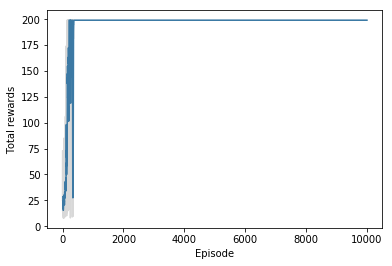

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

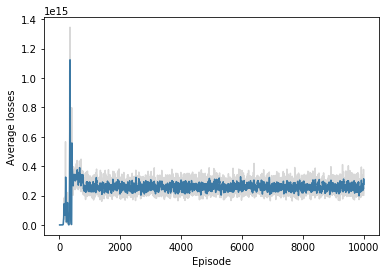

In [20]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.